In [1]:
import numpy as np
import pandas as pd
import mido
from pathlib import Path

Expects to have the dataset unzipped at the project root under `maestro`.
Not committed due to size.

In [2]:
data_dir = Path('../maestro/maestro-v3.0.0/')
df = pd.read_csv(data_dir / 'maestro-v3.0.0.csv')
df.head()

,canonical_composer,canonical_title,split,year,midi_filename,audio_filename,duration
0,Alban Berg,Sonata Op. 1,train,2018,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,698.661160
1,Alban Berg,Sonata Op. 1,train,2008,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,759.518471
2,Alban Berg,Sonata Op. 1,train,2017,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,464.649433
3,Alexander Scriabin,"24 Preludes Op. 11, No. 13-24",train,2004,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,872.640588
4,Alexander Scriabin,"3 Etudes, Op. 65",validation,2006,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,397.857508


Can load the file and explore the `messages`, which hold notes and other actions.
Likely to just have track 0 and 1 per file.
Track 0 holds only metadata, track 1 holds the whole song.

In [3]:
filename = data_dir / df.iloc[0]['midi_filename']
print(filename)
mid = mido.MidiFile(filename)
messages = []
for i, track in enumerate(mid.tracks):
    print('Track {}: {}'.format(i, track.name))
    for msg in track:
        messages.append(msg.dict())

..\maestro\maestro-v3.0.0\2018\MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--1.midi
Track 0: 
Track 1: 


Looking at the start of the messages, we should be able to roughly figure out what kind of note they are by combining time, note ons and offs, and the time signature metadata.
Need to verify on all the files, but looks like `note_off` actions might not be included.
Instead, setting the velocity to 0 is likely how the note ends.

Time is incremental, so the second note is hit 615 ticks after the first.
Then 20 ticks later, the first note lifts off.

It doesn't look like chords are actually hit at the same time.
In the sheet music, rows 13, 15, 17, and 18 are all part of a chord played at the same time.
The ticks are so granular that here they range across ~30 ticks.

In [4]:
messages = pd.DataFrame(messages)
print(messages.shape)
messages.head(20)

(23945, 13)


,type,tempo,time,numerator,denominator,clocks_per_click,notated_32nd_notes_per_beat,program,channel,control,value,note,velocity
0,set_tempo,500000.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,time_signature,NaN,0,4.0,4.0,24.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN
2,end_of_track,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,program_change,NaN,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,control_change,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,64.0,127.0,NaN,NaN
5,note_on,NaN,755,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,67.0,52.0
6,note_on,NaN,615,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,72.0,67.0
7,note_on,NaN,20,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,67.0,0.0
8,note_on,NaN,74,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,72.0,0.0
9,control_change,NaN,128,NaN,NaN,NaN,NaN,NaN,0.0,64.0,117.0,NaN,NaN


No `note_off` messages as mentioned.
Control changes are things like changing volume or pedals.

In [5]:
messages.type.value_counts()

type
control_change    15546
note_on            8394
end_of_track          2
set_tempo             1
time_signature        1
program_change        1
Name: count, dtype: int64

Type 64 is sustain pedal on and off.
Type 67 is soft pedal on and off.

In [6]:
messages.control.value_counts()

control
64.0    13165
67.0     2381
Name: count, dtype: int64

Seems like we mostly care about `note_on` events where the velocity is > 0, meaning the note was played.
This should be a way to create a vectorized `bag of notes`, though it should be sorted by note.
MIDI numbers appear to range from 21 to 108 for 88 total notes.
72 of them are included in this song, which actually seems quite high.

In [7]:
messages[messages.velocity > 0].note.value_counts()

note
62.0     146
66.0     140
60.0     140
71.0     132
67.0     131
        ... 
28.0       4
95.0       3
29.0       3
27.0       1
102.0      1
Name: count, Length: 72, dtype: int64

Theoretically could have multiple channels, but I don't expect that's happening with our simple piano files.

In [8]:
messages.channel.value_counts()

channel
0.0    23941
Name: count, dtype: int64

In [9]:
messages['time_from_start'] = messages.time.cumsum()
messages.head(20)

,type,tempo,time,numerator,denominator,clocks_per_click,notated_32nd_notes_per_beat,program,channel,control,value,note,velocity,time_from_start
0,set_tempo,500000.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,time_signature,NaN,0,4.0,4.0,24.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,0
2,end_of_track,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,program_change,NaN,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,1
4,control_change,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,64.0,127.0,NaN,NaN,1
5,note_on,NaN,755,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,67.0,52.0,756
6,note_on,NaN,615,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,72.0,67.0,1371
7,note_on,NaN,20,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,67.0,0.0,1391
8,note_on,NaN,74,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,72.0,0.0,1465
9,control_change,NaN,128,NaN,NaN,NaN,NaN,NaN,0.0,64.0,117.0,NaN,NaN,1593


In [10]:
notes = messages[messages.type == 'note_on']
notes[['time', 'note', 'velocity', 'time_from_start']]

,time,note,velocity,time_from_start
5,755,67.0,52.0,756
6,615,72.0,67.0,1371
7,20,67.0,0.0,1391
8,74,72.0,0.0,1465
13,11,78.0,65.0,1650
...,...,...,...,...
23737,24,35.0,21.0,524155
23750,169,47.0,0.0,524742
23786,26,35.0,0.0,528043
23799,373,50.0,0.0,530773


In [11]:
notes['next_start'] = notes.groupby('note').shift(-1)['time_from_start']
notes['duration'] = notes.next_start - notes.time_from_start
notes[:20]

C:\Users\benkc\AppData\Local\Temp\ipykernel_42864\995213935.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  notes['next_start'] = notes.groupby('note').shift(-1)['time_from_start']
C:\Users\benkc\AppData\Local\Temp\ipykernel_42864\995213935.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  notes['duration'] = notes.next_start - notes.time_from_start


,type,tempo,time,numerator,denominator,clocks_per_click,notated_32nd_notes_per_beat,program,channel,control,value,note,velocity,time_from_start,next_start,duration
5,note_on,NaN,755,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,67.0,52.0,756,1391.0,635.0
6,note_on,NaN,615,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,72.0,67.0,1371,1465.0,94.0
7,note_on,NaN,20,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,67.0,0.0,1391,1676.0,285.0
8,note_on,NaN,74,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,72.0,0.0,1465,16770.0,15305.0
13,note_on,NaN,11,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,78.0,65.0,1650,2766.0,1116.0
15,note_on,NaN,2,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,71.0,45.0,1655,3322.0,1667.0
17,note_on,NaN,5,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,61.0,39.0,1674,2492.0,818.0
18,note_on,NaN,2,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,67.0,39.0,1676,2428.0,752.0
50,note_on,NaN,206,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,67.0,0.0,2428,3671.0,1243.0
51,note_on,NaN,64,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,61.0,0.0,2492,12460.0,9968.0


In [12]:
notes = notes[notes.velocity > 0]
notes

,type,tempo,time,numerator,denominator,clocks_per_click,notated_32nd_notes_per_beat,program,channel,control,value,note,velocity,time_from_start,next_start,duration
5,note_on,NaN,755,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,67.0,52.0,756,1391.0,635.0
6,note_on,NaN,615,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,72.0,67.0,1371,1465.0,94.0
13,note_on,NaN,11,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,78.0,65.0,1650,2766.0,1116.0
15,note_on,NaN,2,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,71.0,45.0,1655,3322.0,1667.0
17,note_on,NaN,5,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,61.0,39.0,1674,2492.0,818.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23628,note_on,NaN,23,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,66.0,34.0,516944,517824.0,880.0
23693,note_on,NaN,4,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,50.0,6.0,520414,530773.0,10359.0
23695,note_on,NaN,9,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,54.0,23.0,520435,536573.0,16138.0
23735,note_on,NaN,54,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,47.0,29.0,524124,524742.0,618.0


In [13]:
messages[messages.note == 54]

,type,tempo,time,numerator,denominator,clocks_per_click,notated_32nd_notes_per_beat,program,channel,control,value,note,velocity,time_from_start
613,note_on,NaN,108,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,54.0,62.0,15249
616,note_on,NaN,5,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,54.0,0.0,15370
756,note_on,NaN,8,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,54.0,79.0,19143
758,note_on,NaN,12,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,54.0,0.0,19174
843,note_on,NaN,4,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,54.0,65.0,21990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23263,note_on,NaN,46,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,54.0,0.0,501999
23287,note_on,NaN,9,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,54.0,32.0,502748
23313,note_on,NaN,21,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,54.0,0.0,503093
23695,note_on,NaN,9,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,54.0,23.0,520435


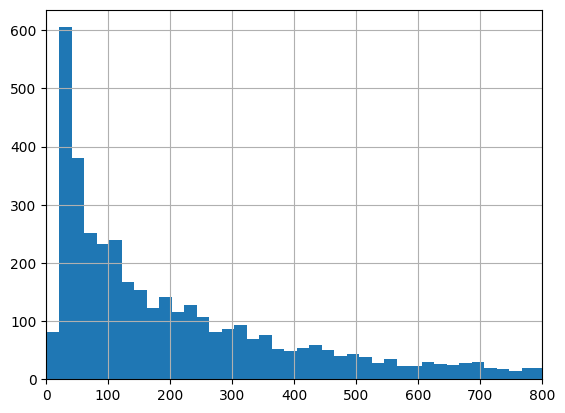

In [14]:
import matplotlib.pyplot as plt
notes.duration.hist(bins=800)
plt.xlim((0, 800))
plt.show()

In [15]:
df.split.value_counts()

split
train         962
test          177
validation    137
Name: count, dtype: int64

In [16]:
df.drop_duplicates(subset=['canonical_composer', 'canonical_title']).split.value_counts()

split
train         585
test          151
validation    120
Name: count, dtype: int64

In [25]:
notes['diff'] = notes['time_from_start']-notes['time_from_start'].shift(1)
notes['new_chord'] = notes['diff'] > 30
notes['chord_id'] = notes['new_chord'].cumsum()
notes[:20]

,type,tempo,time,numerator,denominator,clocks_per_click,notated_32nd_notes_per_beat,program,channel,control,value,note,velocity,time_from_start,next_start,duration,new_chord,chord_id,diff
5,note_on,NaN,755,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,67.0,52.0,756,1391.0,635.0,False,0,NaN
6,note_on,NaN,615,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,72.0,67.0,1371,1465.0,94.0,True,1,615.0
13,note_on,NaN,11,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,78.0,65.0,1650,2766.0,1116.0,True,2,279.0
15,note_on,NaN,2,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,71.0,45.0,1655,3322.0,1667.0,False,2,5.0
17,note_on,NaN,5,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,61.0,39.0,1674,2492.0,818.0,False,2,19.0
18,note_on,NaN,2,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,67.0,39.0,1676,2428.0,752.0,False,2,2.0
53,note_on,NaN,383,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,79.0,58.0,3149,3395.0,246.0,True,3,1473.0
56,note_on,NaN,250,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,79.0,69.0,3645,3944.0,299.0,True,4,496.0
58,note_on,NaN,6,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,60.0,46.0,3658,4156.0,498.0,False,4,13.0
59,note_on,NaN,2,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,70.0,64.0,3660,4031.0,371.0,False,4,2.0


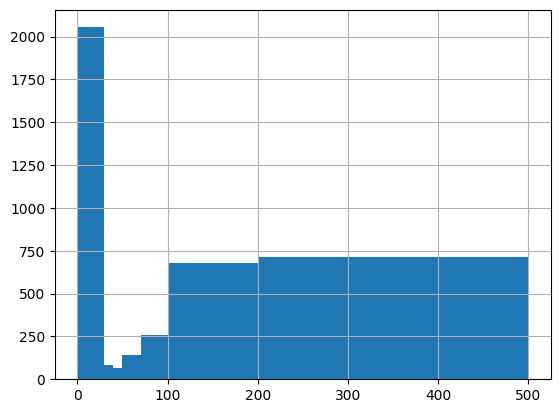

In [29]:
notes['diff'].hist(bins=[0, 30, 40, 50, 70, 100, 200, 500, float('inf')])
plt.show()

In [40]:
chords = notes.groupby('chord_id').aggregate({'note': lambda g: ''.join(g.sort_values().astype(str))})
len(chords.value_counts())

671

In [41]:
chords.value_counts()

note                
60.0                    56
62.0                    51
57.0                    40
66.0                    40
61.0                    38
                        ..
53.059.085.087.0         1
53.059.063.069.0         1
53.058.062.073.0         1
53.058.062.066.073.0     1
96.0                     1
Name: count, Length: 671, dtype: int64

In [36]:
pd.merge(chords.value_counts(), chords.value_counts(), left_index=True, right_index=True)

,count_x,count_y
60,56,56
62,51,51
57,40,40
66,40,40
61,38,38
...,...,...
"64,72,84",1,1
"53,73,85",1,1
"71,72,75,78,84",1,1
"60,67,79",1,1
